In [ ]:
# gsm8k_eval_litellm.py
import openai, time, json, os, re
from datasets import load_dataset
from tqdm import tqdm

client = openai.OpenAI(api_key="sk-key-bLQ", base_url="http://131.220.150.238:8080")
gsm8k = load_dataset("gsm8k", "main")

pf = "progress.json"
results = []
start = 0
if os.path.exists(pf):
    with open(pf) as f:
        results = json.load(f)
        start = len(results)

def extract_final_answer(ex):
    # GSM8K format: "... #### 42"
    return ex["answer"].split("####")[-1].strip()

def ucount(r):
    try:
        u = r.usage
        pt = getattr(u, "prompt_tokens", None)
        tot = getattr(u, "completion_tokens", 0)  # total output tokens from model
        d = getattr(u, "completion_tokens_details", None)
        rt = getattr(d, "reasoning_tokens", 0) if d else 0  # reasoning tokens separately
        return pt, tot, rt
    except:
        return None, None, 0

# --- NEW: helpers to parse and normalize the model output ---
SEP = "####"

def parse_model_output(text):
    """
    Expect: '<answer> #### <step-by-step explanation>'
    Returns (answer_str, explanation_str).
    Robust to extra spaces or newlines around the separator.
    """
    parts = text.split(SEP, 1)
    if len(parts) == 1:
        # Separator missing; treat entire text as the answer, no explanation
        return parts[0].strip(), ""
    ans, expl = parts[0].strip(), parts[1].strip()
    return ans, expl

_num_cleanup = re.compile(r"[,\s]")

def normalize_number(s):
    """
    Normalize numeric strings for comparison:
    - strip whitespace
    - remove commas/spaces
    - drop trailing period
    """
    s = s.strip()
    s = _num_cleanup.sub("", s)
    if s.endswith("."):
        s = s[:-1]
    # remove leading '+'
    if s.startswith("+"):
        s = s[1:]
    return s

def eval_ex(ex):
    q, gt = ex["question"], extract_final_answer(ex)

    # --- UPDATED PROMPT: answer + '####' + explanation ---
    prompt = (
        "Solve the problem. Respond on ONE line only in this exact format:\n"
        "<final numeric answer> #### <step-by-step explanation>\n\n"
        "Rules:\n"
        "- The final answer must be NUMBERS ONLY (no units, no commas, no words, no trailing dot).\n"
        "- Then a space, then exactly four dashes '####', then a space.\n"
        "- After that, give a concise step-by-step explanation.\n\n"
        f"Question: {q}"
    )

    while True:
        try:
            t0 = time.time()
            r = client.chat.completions.create(
                model="google/gemini-2.5-flash",
                messages=[{"role": "user", "content": prompt}],
            )
            t1 = time.time()

            raw = r.choices[0].message.content.strip()
            pred_ans, pred_expl = parse_model_output(raw)

            ok = normalize_number(pred_ans) == normalize_number(gt)

            pt, tot, rt = ucount(r)
            print("[SUCCESS]")
            return {
                "question": q,
                "ground_truth_answer": gt,
                "predicted_answer": pred_ans,
                "step_by_step_explanation": pred_expl,   # <-- NEW COLUMN
                "correct": ok,
                "compute_time": t1 - t0,
                "prompt_tokens": pt,
                "total_output_tokens": tot,
                "reasoning_tokens": rt,
            }
        except Exception as e:
            msg = str(e)
            print(f"[ERROR] {msg[:200]}")
            if "PerDay" in msg or "rate limit" in msg.lower():
                print("[DAILY LIMIT REACHED] Exiting.")
                exit(1)
            print("[WAIT] Retrying after 3 seconds...")
            time.sleep(3)

for i in tqdm(range(start, len(gsm8k["train"]))):
    ex = gsm8k["train"][i]
    print(f"\n[Q#{i}] {ex['question'][:100]}")
    while True:
        r = eval_ex(ex)
        if r:
            results.append(r)
            with open(pf, "w") as f:
                json.dump(results, f, indent=2)
            break
        else:""
            print("[RETRYING] due to failure...")
            time.sleep(10)


C:\Users\umutc\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since gsm8k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'main' at C:\Users\umutc\.cache\huggingface\datasets\gsm8k\main\0.0.0\e53f048856ff4f594e959d75785d2c2d37b678ee (last modified on Thu Jun  5 11:56:29 2025).
0it [00:00, ?it/s]


In [62]:
import json, os

files = ["progress.json", "verified_progress_4.json", "verified_progress_8.json", "verified_progress_16.json","verified_progress_32.json","verified_progress_64.json", "verified_progress_128.json" ,"verified_progress_256.json" ,"verified_progress_512.json"]

for f in files:
    if os.path.exists(f):
        with open(f) as j:
            data = json.load(j)
        print(f"{f}: {len(data)} rows")
    else:
        print(f"{f}: not found")


progress.json: 7473 rows
verified_progress_4.json: 1217 rows
verified_progress_8.json: 323 rows
verified_progress_16.json: 77 rows
verified_progress_32.json: not found
verified_progress_64.json: 7473 rows
verified_progress_128.json: 7473 rows
verified_progress_256.json: 7473 rows
verified_progress_512.json: 7473 rows


In [ ]:
import openai, time, json, os
from datasets import load_dataset
from tqdm import tqdm

client = openai.OpenAI(api_key="sk-key-bLQ", base_url="http://131.220.150.238:8080")
gsm8k = load_dataset("gsm8k", "main")
with open("progress.json") as f: dataset = json.load(f)

def verify_prediction_new(example, budget):
    q, ans, expl = example["question"], example["predicted_answer"], example["step_by_step_explanation"]
    prompt = (f"You need to verify the following answer to the question. "
              f"the question: {q} the answer: {ans}. "
              f"The step-by-step explanation is: {expl}. "
              f"You don't need to solve the question, just verify the answer as directly as possible. "
              f"At the end of thinking, only output one of the words \"true\" or \"false\".")
    while True:
        try:
            start=time.time()
            response = client.chat.completions.create(
                model="gemini/gemini-2.5-flash",
                messages=[{"role": "user", "content": prompt}],
                extra_body={
                    "thinking": {"type": "enabled", "budget_tokens": budget}
                },
            )
            end=time.time()
            msg=(response.choices[0].message.content 
                 if hasattr(response.choices[0],"message") else response.choices[0].text)
            result=msg.strip().lower()
            usage=response.usage
            reasoning_tokens = 0
            if hasattr(usage, "completion_tokens_details") and usage.completion_tokens_details:
                reasoning_tokens = getattr(usage.completion_tokens_details, "reasoning_tokens", 0)
            print(f"[SUCCESS] budget={budget}")
            return {**example,
                    "verification_output": result,
                    "verification_compute_time": end-start,
                    "verification_prompt_tokens": usage.prompt_tokens,
                    "verification_total_output_tokens": usage.completion_tokens,
                    "verification_reasoning_tokens": reasoning_tokens}
        except Exception as e:
            msg=str(e); print(f"[ERROR] budget={budget}, {msg[:200]}")
            if "PerDay" in msg or "rate limit" in msg.lower(): 
                print("[DAILY LIMIT REACHED] Exiting."); exit(1)
            print("[WAIT] Retrying after 5 seconds...")
            time.sleep(5)


reasoning_lengths=[4,8,16,32,64,128,256,512]

for length in reasoning_lengths:
    verified_file=f"verified_progress_{length}.json"
    verified_data=[]
    start_idx=0
    if os.path.exists(verified_file):
        with open(verified_file) as f: 
            verified_data=json.load(f)
            start_idx=len(verified_data)

    print(f"--- Processing dataset for budget={length} ---")
    for i in tqdm(range(start_idx, len(dataset))):
        ex = dataset[i]
        print(f"\n[VERIFY EXAMPLE #{i} budget={length}] {ex['question'][:100]}")
        result = verify_prediction_new(ex, length)
        verified_data.append(result)
        with open(verified_file,"w") as f: json.dump(verified_data,f,indent=2)

    print(f"Total verified rows for budget={length}: {len(verified_data)}")


[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1936/7473 [29:19<1:48:43,  1.18s/it]


[VERIFY EXAMPLE #1936 budget=4] Josh gets together with 7 friends.  Everyone including him puts 5 dollars into a pot.  First place g
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1937/7473 [29:19<1:38:58,  1.07s/it]


[VERIFY EXAMPLE #1937 budget=4] On Friday, Hank opened his used-bicycle store with a stock of bicycles, all fixed-up and ready to ri
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1938/7473 [29:21<1:47:59,  1.17s/it]


[VERIFY EXAMPLE #1938 budget=4] Alicia has to buy some books for the new school year. She buys 2 math books, 3 art books, and 6 scie
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1939/7473 [29:22<1:58:52,  1.29s/it]


[VERIFY EXAMPLE #1939 budget=4] Half of Jerome's money was $43. He gave $8 to Meg and thrice as much to Bianca. How much does Jerome
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1940/7473 [29:23<1:52:30,  1.22s/it]


[VERIFY EXAMPLE #1940 budget=4] At the pet shop, there were 3 birds, 5 dogs, 4 snakes, and 1 spider for sale. How many legs were the
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1941/7473 [29:24<1:48:08,  1.17s/it]


[VERIFY EXAMPLE #1941 budget=4] Saheed made four times as much money as Kayla. Kayla made $30 less than Vika. Vika made $84. How man
[SUCCESS] budget=4


 26%|███████████████████▋                                                        | 1941/7473 [29:25<1:23:52,  1.10it/s]


KeyboardInterrupt: 

In [63]:
import os, json, pandas as pd

def inspect_one(length):
    file = f"verified_progress_{length}.json"
    with open(file) as f:
        data = json.load(f)
    for ex in data:
        if ex.get("verification_output") == "true":
            print("predicted_answer:", ex.get("predicted_answer"), type(ex.get("predicted_answer")))
            print("answer:", ex.get("ground_truth_answer"), type(ex.get("ground_truth_answer")))
            return ex
    return None

sample = inspect_one(4)   # örnek olarak 64
print("raw sample:", sample)


predicted_answer: 72 <class 'str'>
answer: 72 <class 'str'>
raw sample: {'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'ground_truth_answer': '72', 'predicted_answer': '72', 'step_by_step_explanation': 'Natalia sold 48 clips in April. In May, she sold half as many, which is 48 / 2 = 24 clips. Altogether, she sold 48 + 24 = 72 clips.', 'correct': True, 'compute_time': 2.096312999725342, 'prompt_tokens': 128, 'total_output_tokens': 220, 'reasoning_tokens': 168, 'verification_output': 'true', 'verification_compute_time': 2.8293092250823975, 'verification_prompt_tokens': 154, 'verification_total_output_tokens': 3, 'verification_reasoning_tokens': 2}


In [12]:
import os, json, pandas as pd

def verifier_stats(data):
    total = len(data)
    model_correct = 0
    verifier_true = 0
    both_correct_false = 0   # hem model yanlış hem verifier false
    agree = 0
    for ex in data:
        m_ok = bool(ex.get("correct"))
        v_true = ex.get("verification_output") == "true"
        if m_ok: model_correct += 1
        if v_true: verifier_true += 1
        if (not m_ok) and (not v_true): both_correct_false += 1
        if m_ok == v_true: agree += 1
    return total, model_correct, verifier_true, both_correct_false, agree

results = []
for length in [64,128,256,512]:
    file = f"verified_progress_{length}.json"
    if os.path.exists(file):
        with open(file) as f:
            data = json.load(f)
        total, model_correct, verifier_true, both_false, agree = verifier_stats(data)
        results.append({
            "max_tokens": length,
            "total_rows": total,
            "model_correct_count": model_correct,
            "verifier_true_count": verifier_true,
            "both_false_count": both_false,
            "agreement_count": agree,
            "agreement_ratio": agree / total if total else float('nan')
        })

df = pd.DataFrame(results)
print(df)


   max_tokens  total_rows  model_correct_count  verifier_true_count  \
0          64        7473                 7136                 7344   
1         128        7473                 7136                 7337   
2         256        7473                 7136                 7367   
3         512        7473                 7136                 7394   

   both_false_count  agreement_count  agreement_ratio  
0                52             7111         0.951559  
1                55             7110         0.951425  
2                45             7120         0.952763  
3                42             7141         0.955573  


In [ ]:
import openai, json

client = openai.OpenAI(
    api_key="sk-key",  # your key
    base_url="http://131.220.150.238:8080"
)

resp = client.chat.completions.create(
    model="gemini/gemini-2.5-flash",
    messages=[{"role": "user", "content": "What is the capital of France?"}],
    extra_body={
        "thinking": {"type": "enabled", "budget_tokens": 128}
    },
)

# Print nicely
print(json.dumps(resp.to_dict(), indent=2))


{
  "id": "chatcmpl-42024ac3-5d54-402a-81d7-b13c2e911c51",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "The capital of France is **Paris**.",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null,
        "reasoning_content": "**A Straightforward Retrieval**\n\nOkay, so I understand the request. It's a simple one, and it's something I've encountered countless times in my work. The user wants the capital of France. Nothing too complex here. My expertise lies in more nuanced aspects of this field, but a quick and accurate response is always appreciated. Let me just retrieve that fact and present it clearly.\n"
      }
    }
  ],
  "created": 1756673988,
  "model": "gemini-2.5-flash",
  "object": "chat.completion",
  "system_fingerprint": null,
  "usage": {
    "completion_tokens": 34,
    "prompt_tokens": 8,
    "total_tokens": 42,
    "completion_tokens_details": {
      "accepted_prediction

## TESTING THE RESULTS ##


=== Processing verified_progress_4.json ===
Total rows: 1217
FP: 48, TP: 1125, FN: 32, TN: 12
Verification Accuracy: 93.43%


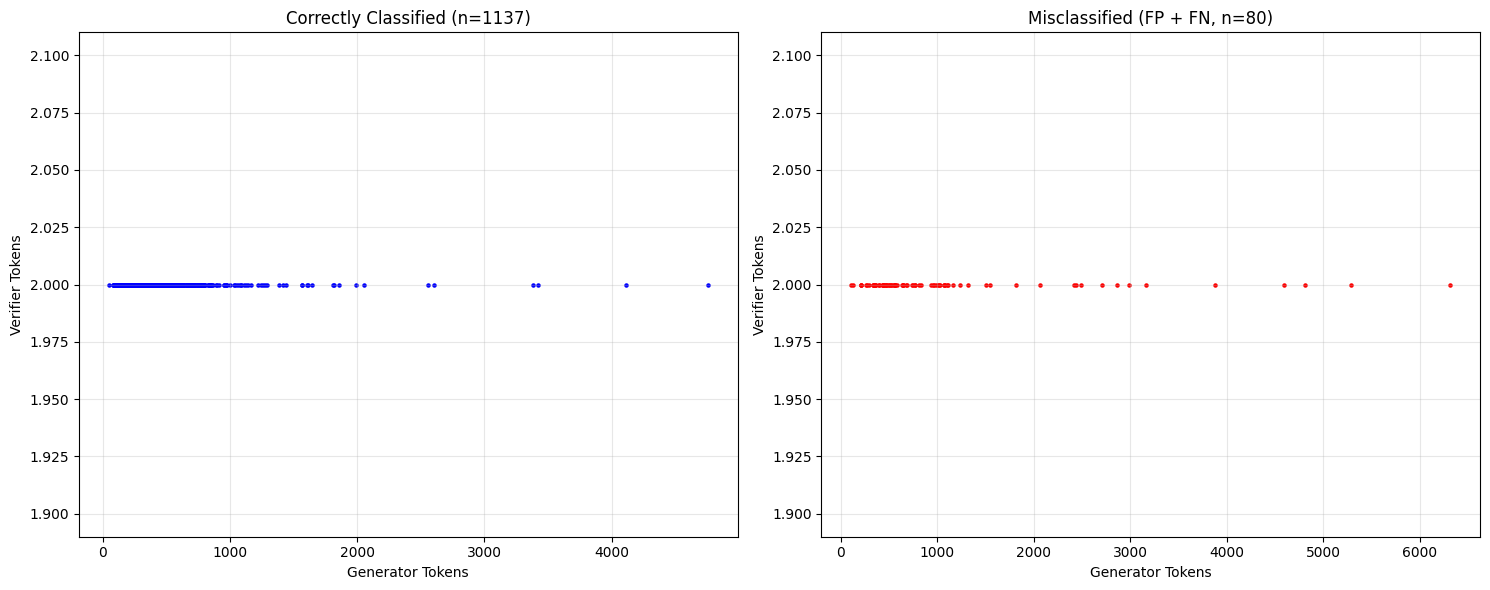


=== Processing verified_progress_8.json ===
Total rows: 323
FP: 10, TP: 305, FN: 7, TN: 1
Verification Accuracy: 94.74%


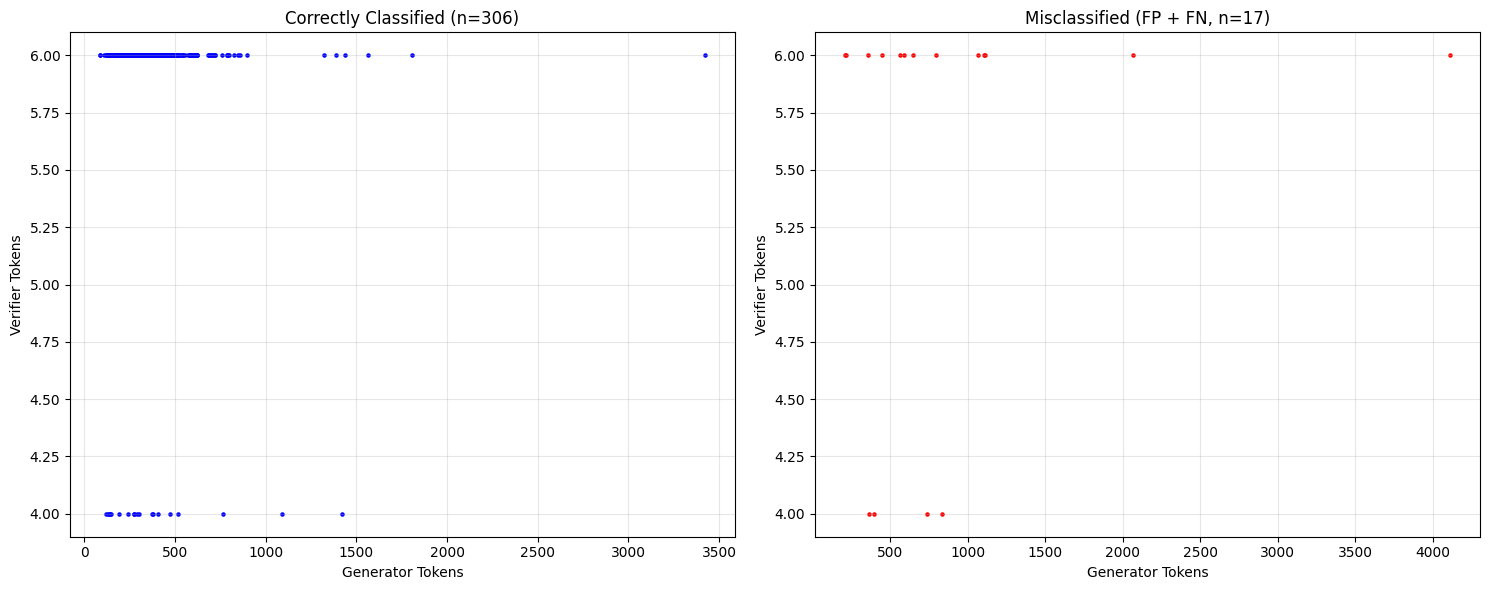


=== Processing verified_progress_16.json ===
Total rows: 77
FP: 2, TP: 75, FN: 0, TN: 0
Verification Accuracy: 97.40%


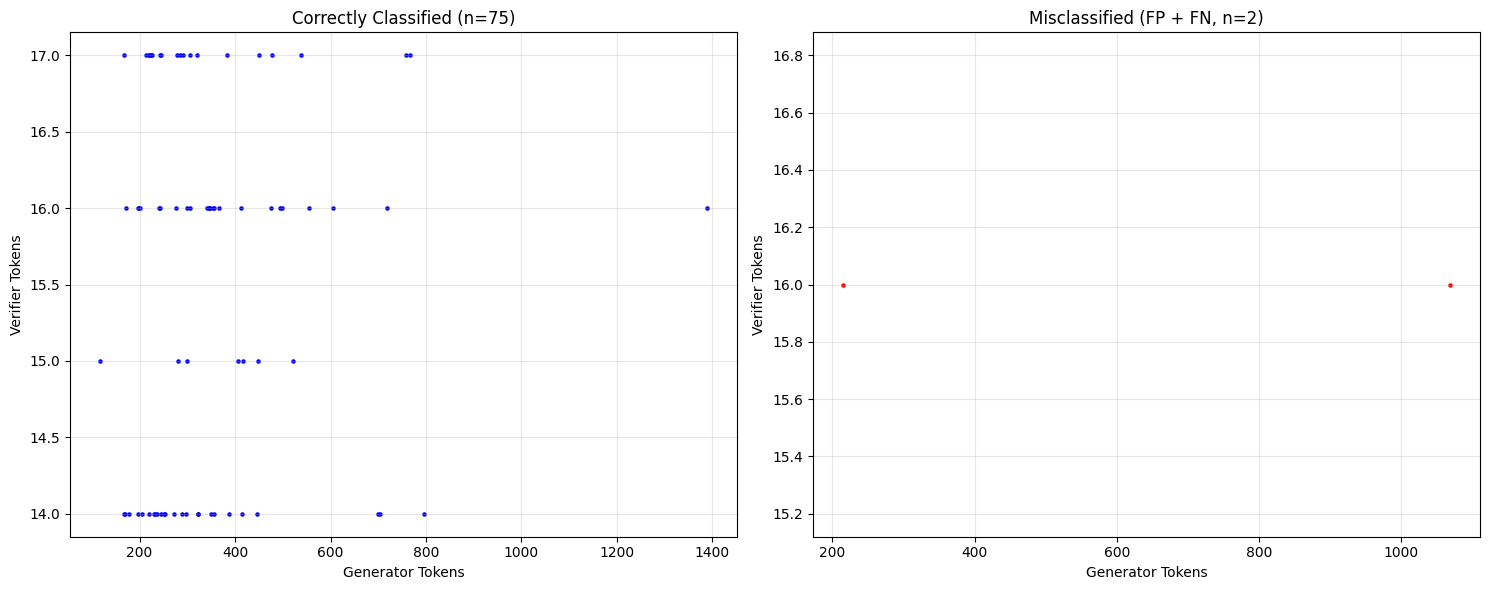


=== Processing verified_progress_64.json ===
Total rows: 7473
FP: 285, TP: 7059, FN: 77, TN: 52
Verification Accuracy: 95.16%


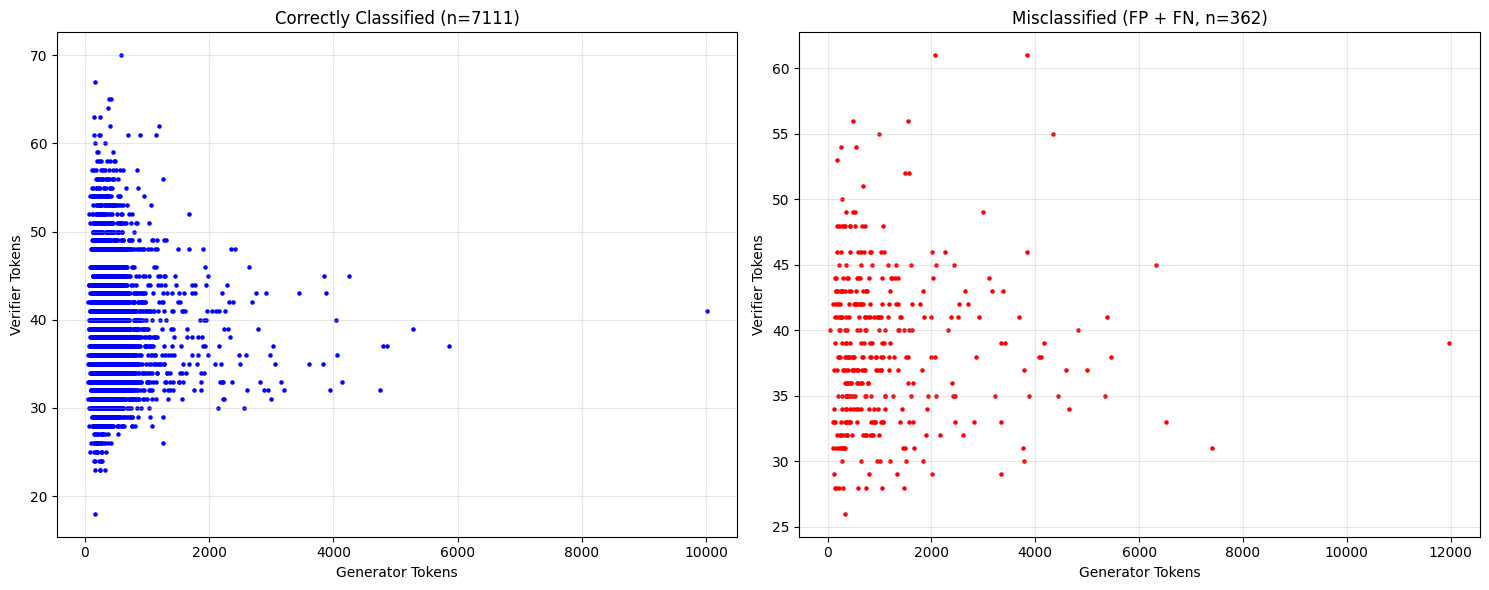


=== Processing verified_progress_128.json ===
Total rows: 7473
FP: 282, TP: 7055, FN: 81, TN: 55
Verification Accuracy: 95.14%


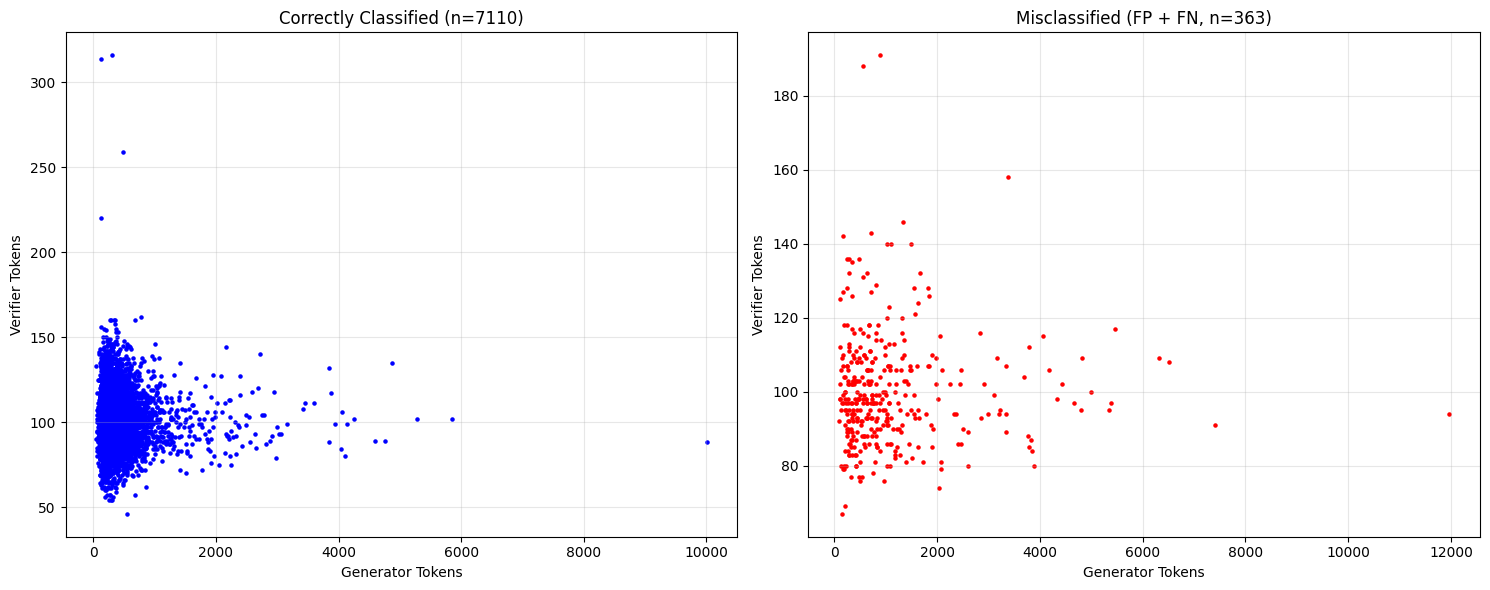


=== Processing verified_progress_256.json ===
Total rows: 7473
FP: 292, TP: 7075, FN: 61, TN: 45
Verification Accuracy: 95.28%


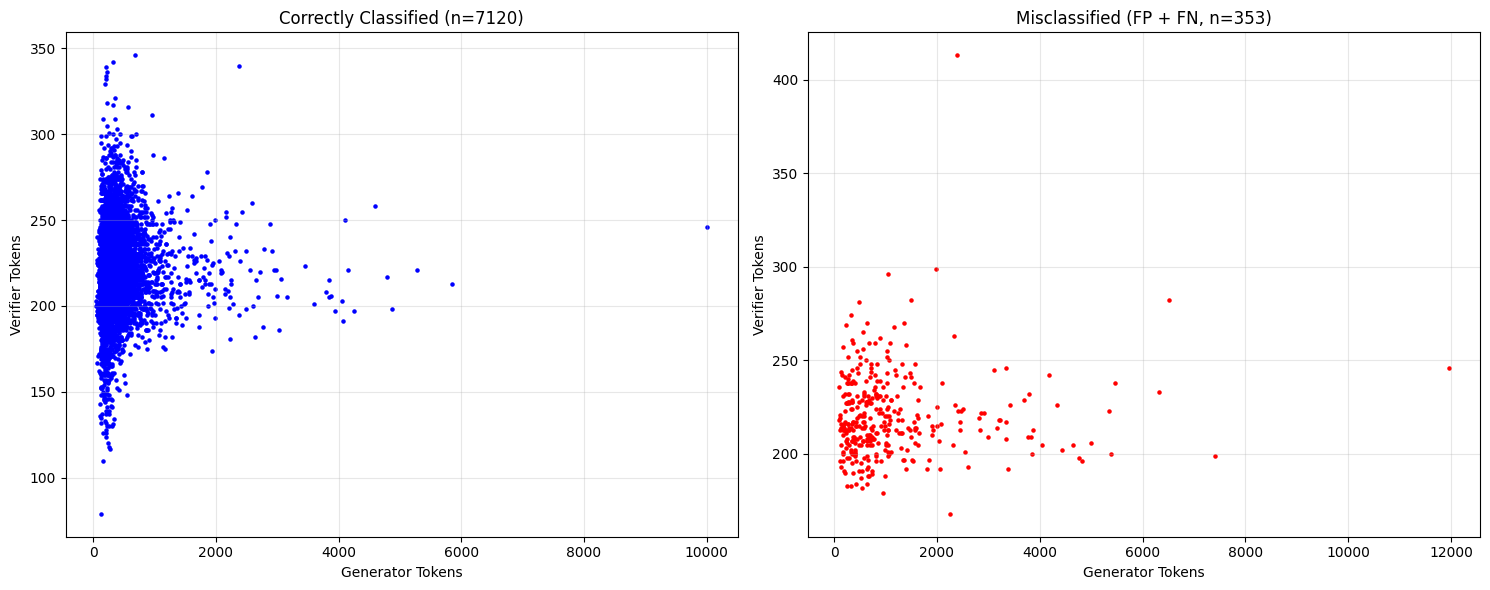


=== Processing verified_progress_512.json ===
Total rows: 7473
FP: 295, TP: 7099, FN: 37, TN: 42
Verification Accuracy: 95.56%


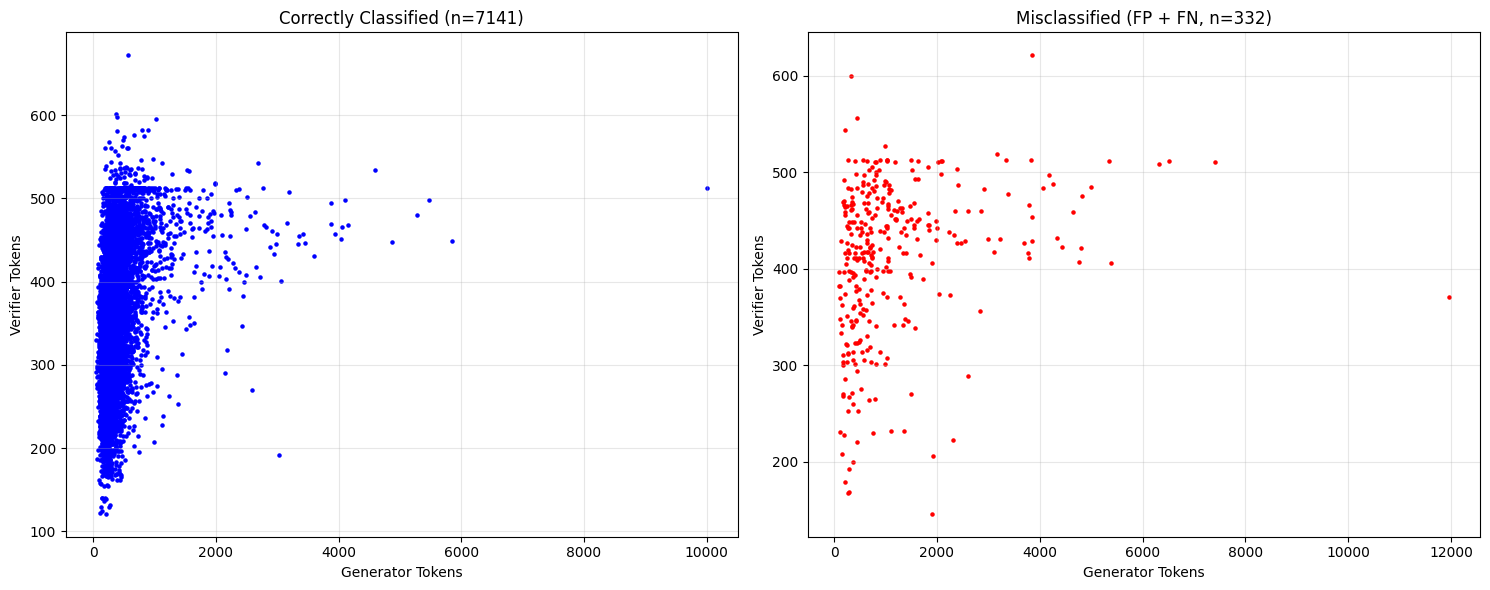

In [65]:
import json
import numpy as np
import matplotlib.pyplot as plt

def analyze_verified_progress(file):
    with open(file) as f:
        data = json.load(f)

    print(f"\n=== Processing {file} ===")
    print("Total rows:", len(data))

    false_positives, correct_cases, false_negatives, true_negatives = [], [], [], []

    for row in data:
        model_correct = row['correct']
        v = row["verification_output"]
        verifier_says_correct = bool(v) if not isinstance(v, str) else v.lower() == "true"

        if not model_correct and verifier_says_correct:
            false_positives.append(row)
        elif model_correct and verifier_says_correct:
            correct_cases.append(row)
        elif model_correct and not verifier_says_correct:
            false_negatives.append(row)
        else:
            true_negatives.append(row)

    print(f"FP: {len(false_positives)}, TP: {len(correct_cases)}, FN: {len(false_negatives)}, TN: {len(true_negatives)}")
    print(f"Verification Accuracy: {(len(correct_cases)+len(true_negatives))/len(data)*100:.2f}%")

    # Prepare tokens
    correct_all = correct_cases + true_negatives
    misclassified_all = false_positives + false_negatives

    correct_gen_tokens = [r["reasoning_tokens"] for r in correct_all]
    correct_ver_tokens = [r["verification_reasoning_tokens"] for r in correct_all]

    mis_gen_tokens = [r["reasoning_tokens"] for r in misclassified_all]
    mis_ver_tokens = [r["verification_reasoning_tokens"] for r in misclassified_all]

    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].scatter(correct_gen_tokens, correct_ver_tokens, alpha=1.0, color='blue', s=5)
    axes[0].set_title(f'Correctly Classified (n={len(correct_all)})')
    axes[0].set_xlabel('Generator Tokens')
    axes[0].set_ylabel('Verifier Tokens')
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(mis_gen_tokens, mis_ver_tokens, alpha=1.0, color='red', s=5)
    axes[1].set_title(f'Misclassified (FP + FN, n={len(misclassified_all)})')
    axes[1].set_xlabel('Generator Tokens')
    axes[1].set_ylabel('Verifier Tokens')
    axes[1].grid(True, alpha=0.3)
    """
    # Keep axes consistent
    all_gen_tokens = correct_gen_tokens + mis_gen_tokens
    all_ver_tokens = correct_ver_tokens + mis_ver_tokens
    axes[0].set_xlim(min(all_gen_tokens), max(all_gen_tokens))
    axes[1].set_xlim(min(all_gen_tokens), max(all_gen_tokens))
    axes[0].set_ylim(min(all_ver_tokens), max(all_ver_tokens))
    axes[1].set_ylim(min(all_ver_tokens), max(all_ver_tokens))
    """

    plt.tight_layout()
    plt.show()


files = [
    "verified_progress_4.json",
    "verified_progress_8.json",
    "verified_progress_16.json",
    #"verified_progress_32.json",
    "verified_progress_64.json",
    "verified_progress_128.json",
    "verified_progress_256.json",
    "verified_progress_512.json"
]

for f in files:
    analyze_verified_progress(f)


## FIT A MODEL ##

In [85]:
import json
files=[#("verified_progress_4.json",4),
       #("verified_progress_8.json",8),
       #("verified_progress_16.json",16),
       ("verified_progress_64.json",64),
       ("verified_progress_128.json",128),
       ("verified_progress_256.json",256),
       ("verified_progress_512.json",512)]
by_q={}
for fname,length in files:
    with open(fname) as f:
        for e in json.load(f):
            q=e.get("question")
            if q is None: continue
            ok=str(e.get("verification_output","")).strip().lower()==str(e.get("correct","")).strip().lower()
            by_q.setdefault(q,[]).append((length,ok,e))
out=[]
for q,entries in by_q.items():
    corrects=[(l,rec) for l,ok,rec in entries if ok]
    if not corrects: continue
    best_len,best_entry=min(corrects,key=lambda x:x[0])
    prompt=f"{q} Predicted answer: {best_entry.get('predicted_answer','')} Explanation: {best_entry.get('step_by_step_explanation','')}"
    out.append({"prompt":prompt,"completion":str(best_len)})
with open("smallest_length_dataset.json","w") as f:
    json.dump(out,f,indent=2)
print("Saved",len(out),"rows")


Saved 7203 rows


In [86]:
import json
from collections import Counter

with open("smallest_length_dataset.json") as f:
    data = json.load(f)

counts = Counter(int(item["completion"]) for item in data)

print("Reasoning Length | Count")
print("-----------------|------")
for length in [4,8,16,64,128,256,512]:
    print(f"{length:<16} | {counts.get(length,0)}")


Reasoning Length | Count
-----------------|------
4                | 0
8                | 0
16               | 0
64               | 7111
128              | 39
256              | 25
512              | 28


## Implementation of the Baseline Model, embedding to logistic regression ##

In [ ]:
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
import openai
import time

# Initialize LiteLLM client
client = openai.OpenAI(
    api_key="sk-key",
    base_url="http://131.220.150.238:8080"
)

# Load dataset
with open("smallest_length_dataset.json", "r") as f:
    dataset = json.load(f)

texts = [d["prompt"] for d in dataset]
labels = [d["completion"] for d in dataset]

# Step 1: Get embeddings
print("Generating embeddings for all samples...")
start_time = time.time()
embeddings = []
for i, t in enumerate(texts, 1):
    resp = client.embeddings.create(
        model="text-embedding-ada-002",
        input=t
    )
    embeddings.append(resp.data[0].embedding)
    if i % 50 == 0:
        print(f"Processed {i}/{len(texts)} samples")
end_time = time.time()
print(f"Finished generating embeddings in {end_time - start_time:.1f} seconds")

X = np.array(embeddings)
y = np.array(labels)

# Step 2: Train Logistic Regression baseline
print("Training Logistic Regression baseline...")
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)
end_time = time.time()
print(f"Finished training in {end_time - start_time:.1f} seconds")

# Step 3: Evaluate overall accuracy
y_pred = clf.predict(X_test)
overall_acc = accuracy_score(y_test, y_pred)
print("\nOverall baseline accuracy:", overall_acc)

# Step 4: Compute per-class accuracy
classes = sorted(set(y))
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true, pred in zip(y_test, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

print("\nPer-class accuracy:")
for cls in classes:
    if class_total[cls] > 0:
        acc = class_correct[cls] / class_total[cls]
        print(f"Reasoning length {cls}: {acc:.2f} ({class_correct[cls]}/{class_total[cls]})")
    else:
        print(f"Reasoning length {cls}: No samples in test set")

# Step 5: Example prediction
example = "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. Predicted answer: 72 Explanation: Natalia sold 48 clips in April. In May, she sold half as many, which is 48 / 2 = 24 clips. Altogether, she sold 48 + 24 = 72 clips."
print("\nGenerating embedding for example prediction...")
resp = client.embeddings.create(model="text-embedding-ada-002", input=example)
example_embedding = np.array(resp.data[0].embedding).reshape(1, -1)
predicted_length = clf.predict(example_embedding)[0]
print("Predicted smallest reasoning length (baseline) for example:", predicted_length)


Generating embeddings for all samples...
Processed 50/7203 samples
Processed 100/7203 samples
Processed 150/7203 samples
Processed 200/7203 samples
Processed 250/7203 samples
Processed 300/7203 samples
Processed 350/7203 samples
Processed 400/7203 samples
Processed 450/7203 samples
Processed 500/7203 samples
Processed 550/7203 samples
Processed 600/7203 samples
Processed 650/7203 samples
Processed 700/7203 samples
Processed 750/7203 samples
Processed 800/7203 samples
Processed 850/7203 samples
Processed 900/7203 samples
Processed 950/7203 samples
Processed 1000/7203 samples
Processed 1050/7203 samples
Processed 1100/7203 samples
Processed 1150/7203 samples
Processed 1200/7203 samples
Processed 1250/7203 samples
Processed 1300/7203 samples
Processed 1350/7203 samples
Processed 1400/7203 samples
Processed 1450/7203 samples
Processed 1500/7203 samples
Processed 1550/7203 samples
Processed 1600/7203 samples
Processed 1650/7203 samples
Processed 1700/7203 samples
Processed 1750/7203 samples

## Fine tune ada with dataset  problem: most of the problems can be verified with the smallest reasoning. (I used 64,128,256,512) because accuracy is always bigger then 90 percent. Even with reasoning length= 4 tokens. Thus there isnt enough data to train the model for it to get better in different class accuracy. A model that deterministically selects 64 always will also have a good overall accuracy. there is only so little to train the other classes. Reasons: 1. the dataset is too easy for models, they dont even need to think. 2. we give step by step reasoning as well, which helps the model even more, so it doesnt need to think. ##

In [92]:
import json
from sklearn.model_selection import train_test_split

# Load your full dataset
with open("smallest_length_dataset.json", "r") as f:
    dataset = json.load(f)

# Split into train and test
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Save training set for fine-tuning
with open("train_finetune.jsonl", "w") as f:
    for d in train_set:
        f.write(json.dumps(d) + "\n")

# Save test set for later evaluation
with open("test_finetune.jsonl", "w") as f:
    for d in test_set:
        f.write(json.dumps(d) + "\n")

print(f"Training set: {len(train_set)}, Test set: {len(test_set)}")


Training set: 5762, Test set: 1441


In [ ]:
import json
from sklearn.metrics import accuracy_score
from collections import defaultdict
import openai
import time

client = openai.OpenAI(
    api_key="sk-key",
    base_url="http://131.220.150.238:8080"
)

# Load train/test
with open("train_finetune.jsonl", "r") as f:
    train_set = [json.loads(line) for line in f]
with open("test_finetune.jsonl", "r") as f:
    test_set = [json.loads(line) for line in f]

print(f"Loaded {len(train_set)} training examples and {len(test_set)} test examples.")

# 1️⃣ Upload training file
print("Uploading training file...")
upload_resp = client.files.create(
    file=open("train_finetune.jsonl", "rb"),  # <-- rb not r
    purpose="fine-tune"
)
training_file_id = upload_resp.id
print("Upload complete. File ID:", training_file_id)

# 2️⃣ Fine-tune decoder-only model
print("Starting fine-tune...")
finetune_resp = client.finetunes.create(
    training_file=training_file_id,
    model="text-ada-001",
    n_epochs=4
)
ft_job_id = finetune_resp.id
print("Fine-tune job created. Job ID:", ft_job_id)

# 3️⃣ Wait for fine-tune to complete
print("Waiting for fine-tune to complete...")
while True:
    status = client.finetunes.retrieve(ft_job_id)
    print("Current status:", status.status)
    if status.status == "succeeded":
        ft_model_id = status.fine_tuned_model
        print("Fine-tuned model ready! Model ID:", ft_model_id)
        break
    elif status.status in ["failed", "cancelled"]:
        raise RuntimeError(f"Fine-tune failed: {status.status}")
    time.sleep(30)  # check every 30s

Loaded 5762 training examples and 1441 test examples.
Uploading training file...


InternalServerError: Error code: 500 - {'error': {'message': 'files_settings is not set, set it on your config.yaml file.', 'type': 'None', 'param': 'None', 'code': '500'}}

In [ ]:
# 4️⃣ Evaluate on test set
print("Starting evaluation on test set...")
y_true, y_pred = [], []

for i, d in enumerate(test_set, 1):
    prompt = d["prompt"]
    resp = client.completions.create(
        model=ft_model_id,
        prompt=prompt,
        max_tokens=10
    )
    pred_length = int(resp.choices[0].text.strip())
    y_pred.append(pred_length)
    y_true.append(int(d["completion"].strip()))
    
    if i % 50 == 0 or i == len(test_set):
        print(f"Processed {i}/{len(test_set)} test examples...")

# Overall accuracy
overall_acc = accuracy_score(y_true, y_pred)
print("\nFine-tuned model overall accuracy:", overall_acc)

# Per-class accuracy
classes = sorted(set(y_true))
class_correct, class_total = defaultdict(int), defaultdict(int)

for true, pred in zip(y_true, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

print("\nPer-class accuracy:")
for cls in classes:
    acc = class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
    print(f"Reasoning length {cls}: {acc:.2f} ({class_correct[cls]}/{class_total[cls]})")
